## Import Librairies & Dependencis

In [1]:
import sys
import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# DATA MANIPULATION
import random
import numpy as np
import pandas as pd
import pandas.api.types
from scipy import stats
from scipy.stats import *
import scipy.ndimage as ndi

# DATA VISUALIZATION - PLOTS
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

# IMAGE PREPROCESSING & VISUALIZATION
import time
import cv2
import os, shutil

import gdcm 
import imageio as iio
import nibabel as nib
import pydicom as dicom
import SimpleITK as sitk
import albumentations as A
import ipywidgets as widgets

from PIL import * 
from skimage import * 
from pydicom import *
from glob import glob
from tqdm import tqdm
from pathlib import Path
from pydicom.data import *
from skimage.filters import *
from skimage.exposure import *
from skimage.transform import *
from subprocess import check_output

## 1. Data preprocessing

In [3]:
# Set dataset root
dsroot ='/home/mukwa/Desktop/rsna-2023-abdominal-trauma-detection/'

In [4]:
!ls {dsroot}

image_level_labels.csv	 test_images		   train_images
sample_submission.csv	 test_series_meta.csv	   train_series_meta.csv
segmentations		 train.csv
test_dicom_tags.parquet  train_dicom_tags.parquet


In [5]:
for i in os.listdir(dsroot):
    if os.path.isdir(os.path.join(dsroot, i)):
        print(f'{i} - Directory')
    else:
        print(f'{i} - File')

train_series_meta.csv - File
sample_submission.csv - File
train.csv - File
train_images - Directory
train_dicom_tags.parquet - File
test_series_meta.csv - File
image_level_labels.csv - File
test_images - Directory
segmentations - Directory
test_dicom_tags.parquet - File


#### As per the result obtained above our main directory contains the following files :

    1. image_level_labels.csv - File in csv format*
    2. sample_submission.csv - File in csv format
    3. test_series_meta.csv - File in csv format
    4. train_series_meta.csv - File in csv format
    5. test_dicom_tags.parquet - File in parquet format
    6. train_dicom_tags.parquet - file parquet format
    
    Directory or Folders
        1. train_images
        2. test_images
        3. segmentations

## 2. EDA

#### As per the result, we can conclude that we have six (6) and three directories

In [6]:
train_images = os.listdir(os.path.join(dsroot, 'train_images'))
print('Below is train_images :')
print(f'-> {train_images[0]}')
for dir in os.listdir(os.path.join(dsroot, f'train_images/{train_images[0]}')):
    print(f' --> {dir}')
    for img in os.listdir(os.path.join(dsroot, f'train_images/{train_images[0]}/{dir}'))[:15]:
        print(f' --> {img}')
print(' ... ')

Below is train_images :
-> 64263
 --> 40690
 --> 18.dcm
 --> 14.dcm
 --> 52.dcm
 --> 74.dcm
 --> 143.dcm
 --> 121.dcm
 --> 123.dcm
 --> 8.dcm
 --> 30.dcm
 --> 149.dcm
 --> 49.dcm
 --> 145.dcm
 --> 13.dcm
 --> 138.dcm
 --> 156.dcm
 --> 47672
 --> 189.dcm
 --> 200.dcm
 --> 52.dcm
 --> 74.dcm
 --> 143.dcm
 --> 121.dcm
 --> 123.dcm
 --> 195.dcm
 --> 149.dcm
 --> 174.dcm
 --> 145.dcm
 --> 138.dcm
 --> 156.dcm
 --> 219.dcm
 --> 122.dcm
 ... 


**As per our result, we can conclude the medical imaging or the CT (Computed tomography) scan data, in DICOM format of all patients stored into folders which may contain one or two differents sub-folders named by patient id becaus each patient may have been scanned once or twice. Each scan contains a series of images. In addition, it worth noting that all medical imaging does not have the same bit per pixel, pixel range, and pixel representation**. 

## Load & view labels (in csv format)

In [7]:
train_labels = pd.read_csv(os.path.join(dsroot, 'train.csv'))
print('Training data Rows : %s Columns : %s ' % (str(train_labels.shape[0]), str(train_labels.shape[1])))

Training data Rows : 3147 Columns : 15 


In [8]:
print('Training data Rows : %s Columns : %s ' % (str(train_labels.shape[0]),str(train_labels.shape[1])))

Training data Rows : 3147 Columns : 15 


In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)
memory usage: 368.9 KB


In [10]:
train_labels.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [11]:
# Show all duplicates in dataframe
train_labels.duplicated().sum() 

0

In [12]:
train_labels.nunique()

patient_id               3147
bowel_healthy               2
bowel_injury                2
extravasation_healthy       2
extravasation_injury        2
kidney_healthy              2
kidney_low                  2
kidney_high                 2
liver_healthy               2
liver_low                   2
liver_high                  2
spleen_healthy              2
spleen_low                  2
spleen_high                 2
any_injury                  2
dtype: int64

## Correlation

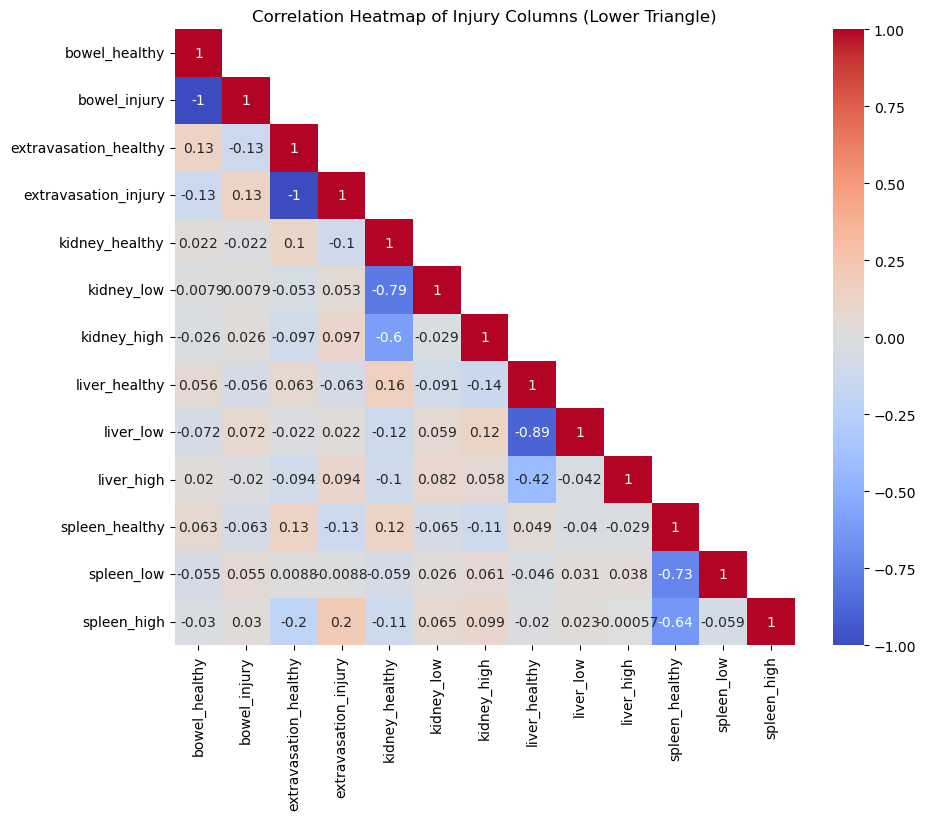

In [13]:
injuries_cols = train_labels.columns[1:-1]

correlation_matrix = pd.DataFrame(index=injuries_cols, columns=injuries_cols)

for i in injuries_cols:
    for j in injuries_cols:
        # Convert categorical values to numeric using Point Biserial Correlation
        r, _ = pointbiserialr(train_labels[i], train_labels[j])
        correlation_matrix.loc[i, j] = r

mask = np.triu(np.ones(correlation_matrix.shape), k=1)

plt.figure(figsize=(10, 8))
sbn.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', center=0, mask=mask)
plt.title('Correlation Heatmap of Injury Columns (Lower Triangle)')
plt.show()

**As shown above there is a weakly or negatively correlation between different categories and healthy. Injuries categories are not correlated each other.**

## Distribution of Injuries by category

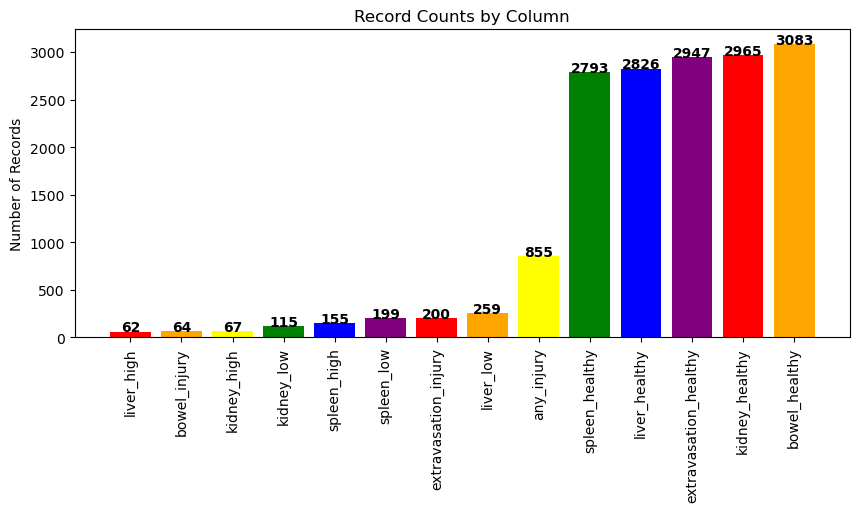

In [14]:
# count the number of records in each column
sum_ = train_labels.iloc[:,1:].sum()

# sort the counts in ascending order
sum_sorted = sum_.sort_values()

plt.figure(figsize=(10, 4))
# create a bar plot of the sorted counts with color
plt.bar(sum_sorted.index, sum_sorted, color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'])
for i, v in enumerate(sum_sorted):
    plt.text(i, v, str(v), color='black', fontweight='bold', ha='center')

# add labels and title
plt.xticks(rotation='vertical')
plt.ylabel('Number of Records')
plt.title('Record Counts by Column')

# display the plot
plt.show()

------------

**In summury, there are 3,147 observations :**

1. Of these, **855** abdominal injuries belong to any injury
2. Of these, **259** abdominal injuries belong to liver low
3. Of these, **200** abdominal injuries belong to extravasation injury
4. Of these, **199** abdominal injuries belong to spleen low
5. Of these, **155** abdominal injuries belong to kidney low
6. Of these, **67** abdominal injuries belong to kidney high
7. Of these, **64** abdominal injuries belong to bowel injury
8. Of these, **62** abdominal injuries belong to liver high

## Diving deep into analysis injuries within category

In [15]:
train_labels['bowel'] = train_labels.iloc[:, 1:3].idxmax(1)
train_labels['extravasation'] = train_labels.iloc[:, 3:5].idxmax(1)
train_labels['kidney'] = train_labels.iloc[:, 5:8].idxmax(1)
train_labels['liver'] = train_labels.iloc[:, 8:11].idxmax(1)
train_labels['spleen'] = train_labels.iloc[:, 11:14].idxmax(1)

train_injuries = train_labels.drop(columns =['bowel_healthy','bowel_injury','extravasation_healthy',
                                             'extravasation_injury','kidney_healthy','kidney_low',
                                             'kidney_high','liver_healthy','liver_low','liver_high',
                                             'spleen_healthy','spleen_low','spleen_high'])
train_injuries.head()

,patient_id,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,bowel_healthy,extravasation_injury,kidney_low,liver_healthy,spleen_high
1,10005,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
2,10007,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
3,10026,0,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy
4,10051,1,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_low


In [16]:
train_injuries.extravasation.value_counts()

extravasation
extravasation_healthy    2947
extravasation_injury      200
Name: count, dtype: int64

**Map bowel_healthy with 0, bowel_injury with 1, same for extravasation and 0 to 2 for healthy-low-high**.

In [17]:
train_injuries['bowel'] = train_injuries['bowel'].map({'bowel_injury':1,'bowel_healthy':0})
train_injuries['extravasation'] =train_injuries['extravasation'].map({'extravasation_injury':1,
                                                                  'extravasation_healthy':0})

train_injuries['kidney'] = train_injuries['kidney'].map({'kidney_low':1,'kidney_high':2,'kidney_healthy':0})
train_injuries['liver'] = train_injuries['liver'].map({'liver_low':1,'liver_high':2,'liver_healthy':0})
train_injuries['spleen'] = train_injuries['spleen'].map({'spleen_low':1,'spleen_high':2,'spleen_healthy':0})

train_injuries.head()

,patient_id,any_injury,bowel,extravasation,kidney,liver,spleen
0,10004,1,0,1,1,0,2
1,10005,0,0,0,0,0,0
2,10007,0,0,0,0,0,0
3,10026,0,0,0,0,0,0
4,10051,1,0,0,0,0,1


In [18]:
train_injuries.extravasation.value_counts()

extravasation
0    2947
1     200
Name: count, dtype: int64

## Pie Chart - distribution of Injuries by category

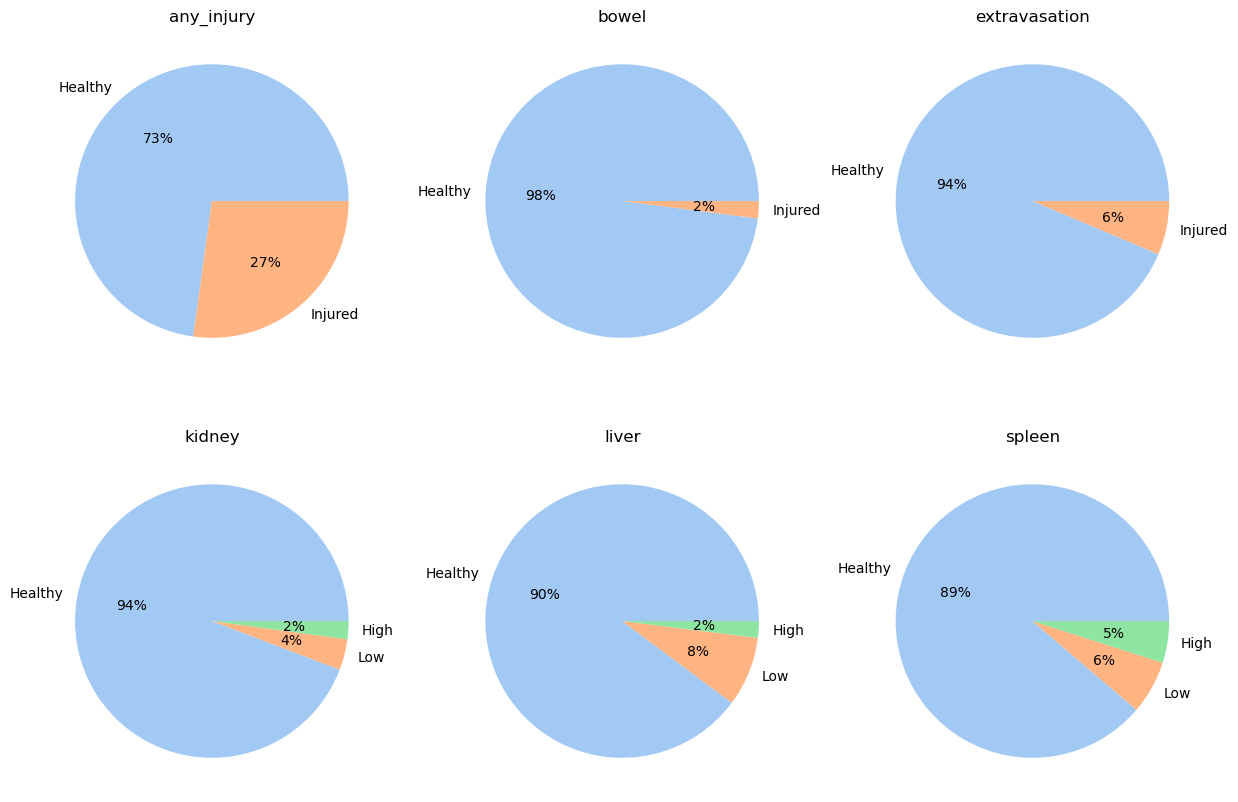

In [19]:
#define Seaborn color palette to use
colors = sbn.color_palette('pastel')[0:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, column in enumerate(train_injuries.columns[1:]):
    axes[idx].set_axis_off()
    ax = axes[idx]
    possible_values = train_injuries[column].nunique()
    if possible_values == 2:
        labels = ['Healthy', 'Injured']
        sizes = train_injuries[column].value_counts().to_dict()
    else:
        labels = ['Healthy', 'Low', 'High']
        sizes = train_injuries[column].value_counts().to_dict()
    ax.pie(sizes.values(), labels=labels, colors = colors, autopct='%.0f%%')
    ax.set_title(column)
plt.show()

-----------

**In summury, it is clear to conclude as per the following findings:**

1. Of these, **27%** abdominal injuries belong to any injury
2. Of these, **8%** abdominal injuries belong to liver low
3. Of these, **6%** abdominal injuries belong to extravasation injury
4. Of these, **6%** abdominal injuries belong to spleen low
5. Of these, **5%** abdominal injuries belong to spleen high
6. Of these, **4%** abdominal injuries belong to kidney low
7. Of these, **2%** abdominal injuries belong to kidney high
8. Of these, **2%** abdominal injuries belong to bowel injury

-----------

## Load & view train series meta dataset(in csv format)

In [20]:
train_series_meta = pd.read_csv(os.path.join(dsroot, 'train_series_meta.csv'))
print('Training data Rows : %s Columns : %s ' % (str(train_series_meta.shape[0]), str(train_series_meta.shape[1])))

Training data Rows : 4711 Columns : 4 


In [21]:
train_series_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        4711 non-null   int64  
 1   series_id         4711 non-null   int64  
 2   aortic_hu         4711 non-null   float64
 3   incomplete_organ  4711 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 147.3 KB


In [22]:
len(train_series_meta[train_series_meta['aortic_hu']<=0])

1

In [23]:
train_series_meta.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [24]:
print('The aortic value is ranged from %s above to %s ' % (str(train_series_meta['aortic_hu'].min()),
                                                               str(train_series_meta['aortic_hu'].max())))

The aortic value is ranged from -1024.0 above to 1411.0 


In [25]:
train_series_meta[train_series_meta['aortic_hu']<=0]

,patient_id,series_id,aortic_hu,incomplete_organ
1742,31284,58351,-1024.0,1


**_The patien shown above has the lowest aortic value, it shows also one or more organs wasn't fully covered by the scan that maybe the reason that lead to that value_**

In [26]:
# Show all duplicates in patient id
train_series_meta.patient_id.duplicated().sum()

1564

In [27]:
# Show all duplicates in patient id
train_series_meta.aortic_hu.duplicated().sum()

3994

In [28]:
train_series_meta.nunique()

patient_id          3147
series_id           4711
aortic_hu            717
incomplete_organ       2
dtype: int64

In [29]:
train_series_meta.pivot_table('patient_id', 'incomplete_organ',
                               aggfunc='count', margins =True, fill_value=0)

,patient_id
incomplete_organ,
0,4398
1,313
All,4711


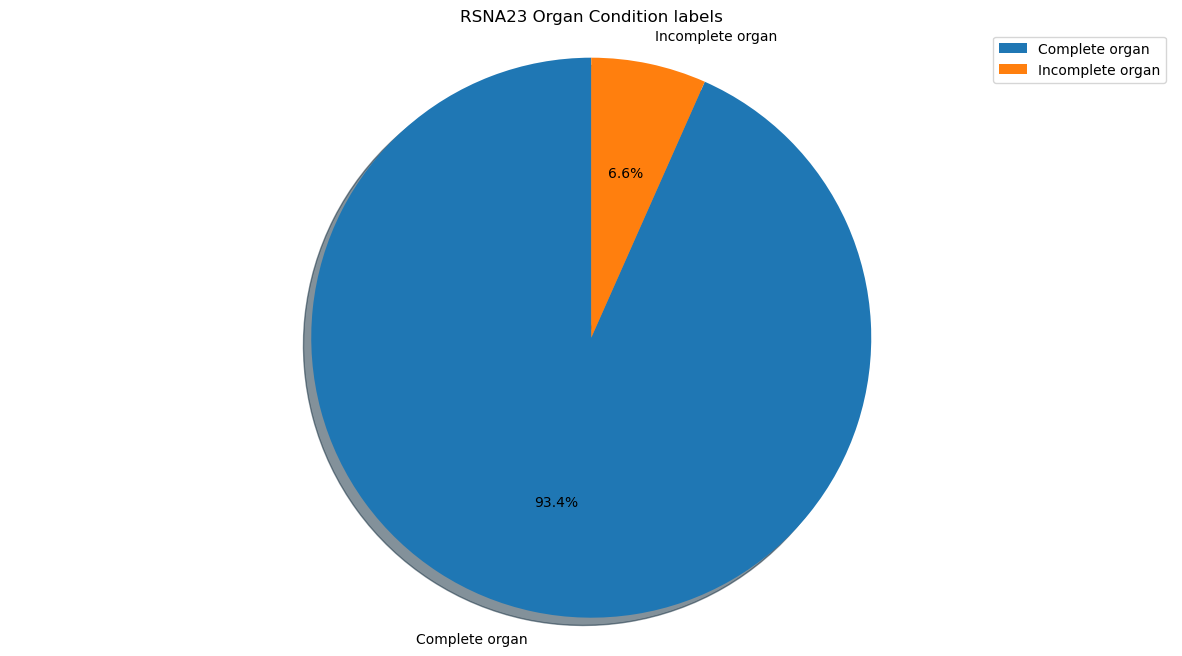

In [30]:
# Plot pie chart
labels = ['Complete organ', 'Incomplete organ']
sizes = train_series_meta.incomplete_organ.value_counts()

fig1, ax1 = plt.subplots(figsize=(15,8))
ax1.pie(sizes, labels = labels, autopct='%1.1f%%', shadow = True, startangle=90)
ax1.axis('equal')
ax1.legend()

plt.title('RSNA23 Organ Condition labels')
plt.show()

In [31]:
# Counting the unique values forincomplete_organ
train_series_meta['incomplete_organ'].value_counts()

incomplete_organ
0    4398
1     313
Name: count, dtype: int64

-----------

**In sum, there are 4711 observations or records**:

  1. Of these, **3,147** unique ID code for each patients
  2. Of these, **4,711** unique ID code for each scan
  3. Of these, **717** images
  4. Of these, **2** binary variable - Thrue if one or more organs was not fully covered by the scan
  5. Of these, **1,564** duplicates ID code - Maybe these patient have been scanned twice
  6. Of these, **3,994** aortic_hu duplicates -Indicate duplicate volume of the aorta was taken.
  7. Of these, **4,398 (93.4%)** patient which the organ was fully covered by the scan.
  8. Of these, **313 (6.6%)** patient which one or more organs was not fully covered by the scan.

-------------

## Load & view train dicom tags dataset (in parquet format)

In [32]:
train_dicom_tags = pd.read_parquet(os.path.join(dsroot, 'train_dicom_tags.parquet'))
print('Training data Rows : %s Columns : %s ' % (str(train_dicom_tags.shape[0]), str(train_dicom_tags.shape[1])))

Training data Rows : 1510373 Columns : 35 


In [33]:
train_dicom_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510373 entries, 0 to 1510372
Data columns (total 35 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   BitsAllocated               1510373 non-null  int64  
 1   BitsStored                  1510373 non-null  int64  
 2   Columns                     1510373 non-null  int64  
 3   ContentDate                 1510373 non-null  object 
 4   ContentTime                 1510373 non-null  object 
 5   FrameOfReferenceUID         1510373 non-null  object 
 6   HighBit                     1510373 non-null  int64  
 7   ImageOrientationPatient     1510373 non-null  object 
 8   ImagePositionPatient        1510373 non-null  object 
 9   InstanceNumber              1510373 non-null  int64  
 10  KVP                         1510373 non-null  float64
 11  PatientID                   1510373 non-null  object 
 12  PatientPosition             1510373 non-null  object 
 1

In [34]:
train_dicom_tags.head()

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path,RescaleType
0,16,16,512,20230722,003306.881589,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1459.20]",532,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.532,1.2.840.10008.1.2.5,train_images/49954/41479/532.dcm,nan
1,16,16,512,20230722,003303.279137,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1474.40]",513,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.513,1.2.840.10008.1.2.5,train_images/49954/41479/513.dcm,nan
2,16,16,512,20230722,003343.090736,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1310.40]",718,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.718,1.2.840.10008.1.2.5,train_images/49954/41479/718.dcm,nan
3,16,16,512,20230722,003252.960345,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1520.00]",456,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.456,1.2.840.10008.1.2.5,train_images/49954/41479/456.dcm,nan
4,16,16,512,20230722,003155.059398,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1756.00]",161,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.161,1.2.840.10008.1.2.5,train_images/49954/41479/161.dcm,nan


In [35]:
train_dicom_tags.nunique()

BitsAllocated                       1
BitsStored                          3
Columns                           136
ContentDate                         2
ContentTime                   1508830
FrameOfReferenceUID              3147
HighBit                             3
ImageOrientationPatient           173
ImagePositionPatient          1426166
InstanceNumber                   1971
KVP                                10
PatientID                        3147
PatientPosition                     2
PhotometricInterpretation           1
PixelRepresentation                 2
PixelSpacing                      807
RescaleIntercept                    4
RescaleSlope                        1
Rows                                6
SOPInstanceUID                1210859
SamplesPerPixel                     1
SeriesInstanceUID                4771
SeriesNumber                      134
SliceThickness                     19
StudyInstanceUID                 3147
WindowCenter                        1
WindowWidth 

------------

**LOAD & VIEW IMAGE LEVEL LABELS (In CSV format)**

In [36]:
image_level_labels = pd.read_csv(os.path.join(dsroot, 'image_level_labels.csv'))
print('Training data Rows : %s Columns : %s ' % (str(image_level_labels.shape[0]), str(image_level_labels.shape[1])))

Training data Rows : 12029 Columns : 4 


In [37]:
image_level_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       12029 non-null  int64 
 1   series_id        12029 non-null  int64 
 2   instance_number  12029 non-null  int64 
 3   injury_name      12029 non-null  object
dtypes: int64(3), object(1)
memory usage: 376.0+ KB


In [38]:
image_level_labels.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [39]:
# Show all duplicates in patient id
image_level_labels.patient_id.duplicated().sum()

11783

In [40]:
# Show all duplicates in series id
image_level_labels.series_id.duplicated().sum()

11699

In [41]:
# Show all duplicates in instance number
image_level_labels.instance_number.duplicated().sum()

11104

In [42]:
image_level_labels.nunique()

patient_id         246
series_id          330
instance_number    925
injury_name          2
dtype: int64

--------

**In sum, there are 12029 observations or records**:

   1. Of these, **246** patients of **330** series.
   2. Of these, **330** series of **246** patients.
   3. Of these, **925** annotated images
   4. Of these, **2** types of Injuries
   5. Of these, **11,783** duplicates patient_id - Maybe these patient have been scanned twice.
   6. Of these, **11,699** duplicates series id - this indicate some scan were done more than twice.
   7. Of these, **11,104** duplicates annotated images instance number -this indicate same image # was assigned more than one.

In [43]:
image_level_labels.pivot_table('patient_id', 'injury_name',
                               aggfunc='count', margins =True, fill_value=0)

,patient_id
injury_name,
Active_Extravasation,6370
Bowel,5659
All,12029


## loading and processing train images

In [44]:
# Define the directory path for the train images
train_images = os.path.join(dsroot, 'train_images')
# initialize counters
num_images = 0
num_series = 0
num_patients = 0
patient_ids = set()

# start the timer
start_time = time.time()

# loop through the directory tree using os.walk()
for root, dirs, files in os.walk(train_images):
    for file in files:
        if file.endswith(".dcm"):
            # read the DICOM file using pydicom
            ds = dicom.dcmread(os.path.join(root, file))
            # check if the NumberOfFrames attribute is present
            if hasattr(ds, "NumberOfFrames"):
                # increment the image counter by the number of frames in the file
                num_images += ds.NumberOfFrames
            else:
                # increment the image counter by 1 for single-frame images
                num_images += 1
            # increment the series counter if this is the first image in the series
            if ds.SeriesNumber == 1:
                num_series += 1
            # add the patient ID to the set of patient IDs
            patient_ids.add(ds.PatientID)

# count the number of unique patient IDs
num_patients = len(patient_ids)

# stop the timer
end_time = time.time()

# calculate the processing time in minutes and seconds
processing_time = end_time - start_time
processing_time_minutes = int(processing_time // 60)
processing_time_seconds = int(processing_time % 60)

# print the results
print("Number of DICOM images:", num_images)
print("Number of series:", num_series)
print("Number of patients:", num_patients)
print("Processing time:", processing_time_minutes, "minutes", processing_time_seconds, "seconds")

Number of DICOM images: 1500653
Number of series: 57572
Number of patients: 3147
Processing time: 30 minutes 27 seconds


In sum, the train images directory contains a total of **1,500,653** dicom images versus **1,510,373** images from train_dicom_tags dataset.That said, there are **9,720** dicom images off. Note having further details, using train_dicom_tags datasets may not be a bad idea. Both train images dataset and train_dicom_tags worth using for deep learning classification

In [45]:
# Initialize the counters for 1 and 2 subfolders
one_sub = 0
two_sub = 0

# Loop through the folders (patient_id) in the main directory
for folder in os.listdir(train_images):
    # Get the full path of the folder
    folder_path = os.path.join(train_images, folder)
    # Check if the folder (patient_id) is a directory
    if os.path.isdir(folder_path):
        # Get the list of subfolders (series_id)in the folder (patient_id)
        subfolders = os.listdir(folder_path)
        # Count the number of subfolders
        num_sub = len(subfolders)
        # Update the counters accordingly
        if num_sub == 1:
            one_sub += 1
        elif num_sub == 2:
            two_sub += 1

# Print the results
print('\n'f'There are {one_sub} patient_id with 1 series_id in train_images directory')
print(f'There are {two_sub} patient_id with 2 series_id in train_images directory')


There are 1583 patient_id with 1 series_id in train_images directory
There are 1564 patient_id with 2 series_id in train_images directory


## Load a view sample submission dataset(in csv format)

In [46]:
sample_submission = pd.read_csv(os.path.join(dsroot, 'sample_submission.csv'))
print('Training data Rows : %s Columns : %s ' % (str(sample_submission.shape[0]), str(sample_submission.shape[1])))

Training data Rows : 3 Columns : 14 


In [47]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             3 non-null      int64  
 1   bowel_healthy          3 non-null      float64
 2   bowel_injury           3 non-null      float64
 3   extravasation_healthy  3 non-null      float64
 4   extravasation_injury   3 non-null      float64
 5   kidney_healthy         3 non-null      float64
 6   kidney_low             3 non-null      float64
 7   kidney_high            3 non-null      float64
 8   liver_healthy          3 non-null      float64
 9   liver_low              3 non-null      float64
 10  liver_high             3 non-null      float64
 11  spleen_healthy         3 non-null      float64
 12  spleen_low             3 non-null      float64
 13  spleen_high            3 non-null      float64
dtypes: float64(13), int64(1)
memory usage: 468.0 bytes


In [48]:
sample_submission.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [49]:
test_dicom_tags = pd.read_parquet(os.path.join(dsroot, 'test_dicom_tags.parquet'))
test_dicom_tags.shape

(3, 35)

#### As shown above, test & the submission data has only three (3) observations or records.

-----------------